# Vanishing/Exploding Gradient problems

* **Vanishing Gradient Problem:** Gradient get smaller and smaller as the algorithm progresses down the lower layers. As a result the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution
* **Exploding Gradient Problem:** In some cases gradients grow bigger and bigger, so many layers get insanely large weight updates and algorithm diverges


Above gradient vanishing and exploding problem is mentioned wrt to gradient. Similar problem also happens when weight matrix is moving away from identity matrix. If the weights matrix moves higher from identity matrix we have Exploding problem by the time it reaches the last layer. similarly if the weights move lower from identity matrix we have gradient vanishing problem where it will explode at the power of L. more deeper more 

Xavier Glorot and Yoshua Bengio: found the two suspects responsible for this problem. 
1. Logistic Sigmoid Activation Function:  
   * Things are meade worse because logistic function has mean at 0.5 not 0
   * when the inputs become large(negative or positive) the function saturates at 0 or 1. With a derivative close to 0. Thus when backpropogation kicks in it has virtually no gradient to propogate back throught the network 
2. Weight Initialization Techniques: (random initialization with normal distribution with mean 0 and sd 1)

In short that they showed that with the above activation function and initialization scheme, the variance of the output of each layer is much greater than the variance of its inputs

In [21]:
import math
#checking behavious of logistic function at high positive and negative values
print(1/(1+ math.exp(-1* 4)) - (1/(1+ math.exp(-1* 4.5))))
print(1/(1+ math.exp(-1* 0)) - (1/(1+ math.exp(-1* 0.5))))
print(1/(1+ math.exp(-1* 1)) - (1/(1+ math.exp(-1* 1.5))))
print(1/(1+ math.exp(-1* -4)) - (1/(1+ math.exp(-1* -4.5))))

-0.00699926733149836
-0.1224593312018546
-0.08651589756363876
0.006999267331498379


# (A) Variable initialization
**Xavier and He Initalization**  
Note:  
* we need a signal to flow properly in both directions: forward when making predictions and in the reverse directions when back propogating gradients.  
* We dont want the signal to die out neither we want the signal to explode or saturate
* For this to happen authors argue that we need the output of a layer to have equal variance as its inputs and also we need the gradients to have equal variance before and after flowing through the a layer in the reverse direction,.

It is actually not possible to gurantee both without having equal number of input and output connections. So authours proposed a good compromise.

Below is the table that shows good intialization for specific activation function based on the distribution chosen for intialization. All have mean 0 but the standard deviation is tweaked wrt to IP and OP connections. If count of inputs is equal to count of outputs things get further simepler

|Activation function | Uniform distribution[-r,r].....|    .......Normal distribution.........|
|-------------------------|-------------------------------------|----------------------------------------|
|Logistic| $ r = \sqrt{\frac{6}{n_{inputs} + n_{ouputs}} }$|$ \sigma = \sqrt{\frac{2}{n_{inputs} + n_{ouputs}} }$|
|hyperbolic tangent| $ r = 4 \times \sqrt{\frac{6}{n_{inputs} + n_{ouputs}} }$|$ \sigma = 4 \times \sqrt{\frac{2}{n_{inputs} + n_{ouputs}} }$|
|ReLU| $ r = \sqrt{2}
\times  \sqrt{\frac{6}{n_{inputs} + n_{ouputs}} }$|$ \sigma =\sqrt{2} \times \sqrt{\frac{2}{n_{inputs} + n_{ouputs}} }$|

Xavier initialization strategy works well in practice and intialization strategy for ReLU is called He initialization  

By default tf.layer.dense uses Xavier initialization and we can change it to he by a sample code shown below  
 ```python

he_init = tf.cotrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu,
                          kernel_initializer = he_init, name = "hidden1")
```


Note:   
He initializer considers only the fan in. But Xavier considers the average of both fan in and fan out. We can change the default of he to average both fan in and fan out by typing mode = "FAN_AVG"

# (B)  Activation Function
## Nonsaturating Activation functions

 ReLU is not perfect because it suffers from a problem called **dying ReLU** During training some neurons efeectively die meaning they stop outputing anything other than 0. When this happen neuron is unlikely to comeback to life since the gradient of the ReLU function is 0 when its input is negative. 
 
 #### Activation Function ReLU
 **Relu**
  $$ ReLU = max(0, z) $$

 #### Activation Function LeakyReLU
 To solve this problem a variant of ReLU is used called **leaky Relu**  
 **Leaky Relu**
  $$ LeakyReLU_{\alpha} = max(\alpha z, z) $$
  
Emeprically $\alpha = 0.01 or 0.02 $  seems to work well 

 #### Activation Function ELU (exponential linear input)
 ELU is claime dto have outperformed LeakyRelu as well
 **ELU**
  $$ ELU_{\alpha} = 
  \begin{cases}
  \alpha(exp(z)-1) & \text{if } z<0\\    
  z & \text{if } z>0    
\end{cases} $$

Emeprically $\alpha = 1 $  seems to work well 

 
**Note on ELU**
* First it takes on a negative value when z<0, which alows the unit to have an average output closer to 0. This helps to alleviate vanishing gradients problem. 
* Second, it has a nonzero gradient for z<0 , which avoids the dying units issue
* the function is smooth everywhere including z=0. Which helps speed up gradient descnt
* (Disadvantage) It is slower to compute than the ReLU and its variants but during training it is compensated by Faster convergance rate. However test time for ELU is greater than ReLU 

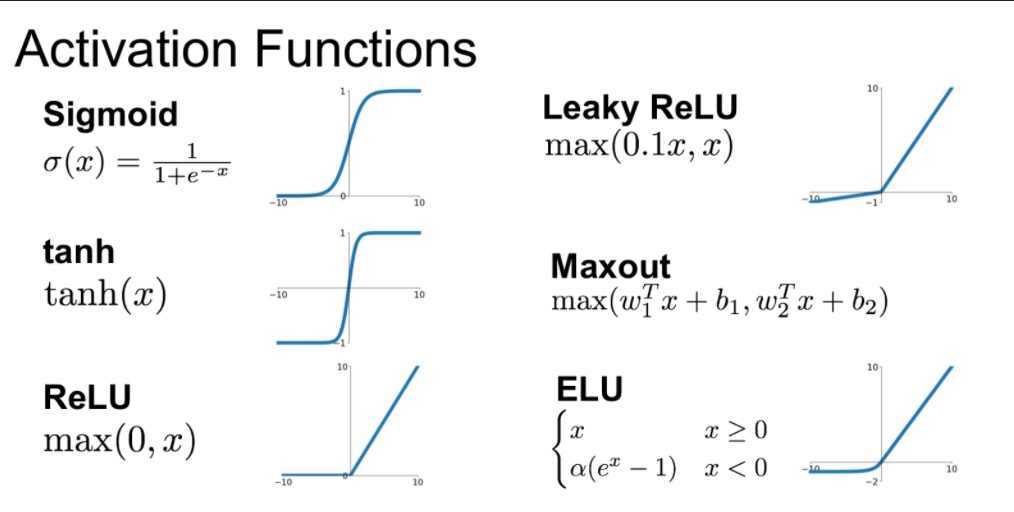

In [13]:
from IPython.display import Image
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' + 
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images\\activationfunctions.png', width = 400)

Note:
* Prefence of activation function is in the order ELU > Leaky ReLU  Variants  > ReLU > Tanh > logistic > step
* Leaky ReLU variants:  
    * RReLU: Randomized Leaky ReLU: $ \alpha$ is picked randomly in the given range during trainng
    * PReLU: Parameterized Leaky ReLU: Here $ \alpha$ becomes parameter from hyperparameter. The alpha is learnt during the training 

**ELU in tensorflow**
```python
hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.elu, name  = "hidden1")
```

**Leaky ReLU in tensorflow**
```python
def leaky_relu(z, name = None):
    return tx.maximum(0.1*z, z, name = name)

hidden1 = tf.layers.dense(X, n_hidden, activation = leaky_relu, name = "hidden1")
```


# (C)  Batch Normalization
## Batch Normalization (Mainly addresse Internal Covariate Shift Problem)

Athough using He initialization and ELU helps in addressing gradien vanishing and exploding problem at the beginning but it does not guarantee that it wont come back during training. 

Bath Normalization proposed by Serge Ioffe and Christian Szegedy. 

**Batch Normalization is a good techniques which solves lot of DNN problwmsRevolutionary **
1. Addresses vanishing/explodieng gradients problem.
 * More generally the problem that distribution of each layer's input changes during training, as the parameters of previous layer change, i.e. Internal Covariate Shift.
 * It greatly reduces vanishing gradient problem to a point that we can end up using saturating activation function such as logistic activation function
2. Now networks were less sensitive to weight initialization
3. Now they could use much larger learning rates significanlty speeding the learning process
4. Batch normalization also acts as a regularizer(reducing the needs for other regulariation techniques)

**Disadvantages of Batch Normalization**
1. Since it requires some extra processing at each layer it will take more time that ELU+He initaliztion technique

### How batch normalization works
This techniques adds an opreation in the model just before the activation function of each layer, 
    * simply zero centring and normalizing  the inputs
    * Scaling and shifting the results
    
In order to zero-center and normalize the inputs the algorithm needs to estimate the mean and sd. IT does this by evaluating mean and sd of the inputs over the current mini batch  (hence the name "Batch Normalization).

At test time there is no mini batch to compute the emperical mean and sd, so instead yuou simply udr the whole training dataset's mean and sd. Typeically four parameters are learned for each batch normalization layer.   
$\gamma \text{ scale}, \beta \text{ shift}, \mu \text{ mean} \sigma \text{ sd} $

#### Batch operation algorithm

$$ \text{1. } {\mu_B} = \frac{1}{m_B} \sum_{i = 1}^{m_B} x^{(i)} $$
$$ \text{2. } {\sigma_B^2} = \frac{1}{m_B} \sum_{i = 1}^{m_B} {(x^{(i)}-\mu_B)^2} $$
$$ \text{3. } {\hat{x}^{(i)}} = \frac{(x^{(i)}-\mu_B)}{\sqrt{\sigma_B^2 + \epsilon}}  $$
$$ \text{4. } {z^{(i)}} = \gamma \hat{x}^{(i)} + \beta  $$

* $\mu_B$ is the emperical mean, evaluated over the whole minibatch B
* $ \sigma_B$ is the emperical sd, also evaluated over the whole mini batch
* $ m_B $ is the number of instances in the mini batch
* $ \hat{x}^{(i)}$ is the zero centered and normalized input
* $\gamma$ is the scaling parameter of the layer
* $ \beta $ is the shifting parameter of the layer
* $\epsilon$ is a tiny number to avoid division by zero (typically $10^-5$). this is called smoothing term
* $ z^{(i)} $ is the outputog th BN operation. It is normalized scaled and shifted version of the inputs

**Note from Andrew NG's Batch normalization video**
* if $\epsilon$ is 0 and  $ \gamma $ is 1 then it is nothing but non scaled and non shifted input. as good as not implementing batch normalization
* Here since there is a shift or $\epsilon$ in the batch normalization process we can just cancell the shift operator in the activation function. 

### Implementing batch normalization with TF

So we get the code that we build in ArtificialNeuralNetwork.ipynb and update the following 
1. STEP 0: getitng partial function from func tools package
2. STEP 3: here we update the layers incorporating batch normalization
    * **Defining training placeholder** we will set it True during training other wise False. This tells tf.layers.batch_normalization() whether it should take the current mini batchs mean and sd or the whole training set's
    * we are incorporating a partial function from functool package that will help us in avoiding redundantly writing long Batch normalization function after every layer again and again
    * here BN in tf uses exponential decay to compute running avgs, so we need momentum(good momentum is typically closer to 1 like .9,.99, .999). Given a new value $v$, the running average $\hat{v}$ is updated in through the equation  
        *  $$ \hat{v} \leftarrow \hat{v} \times momentum + v \times (1-momentum) $$
    * we dont mention activation at tf.layers.dense step itself because we apply activation after batch normalization
3. STEP 10: 2 main changes to the excution phase  
    i. During training whenever we run an operation that depends on batch normalization layer, we need to set the training placeholder to True  
    ii. batch_normalization() creates a few operations that must be evaluated at each step during training inorder to update moving average. These operations are automatically added to update_ops collection. So all we need to do is get the list of operations in that collection and run them at each iteration

In [1]:
############ CONSTRUCTION PHASE

#(0) reset the constrution graph and call all the required libraries
import tensorflow as tf
tf.reset_default_graph()
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now)

import sklearn as sk
import numpy as np
from sklearn.preprocessing import StandardScaler
from functools import partial

#(1) Let us input some basic design of our 
n_inputs = 28*28 #MNIST
n_hidden1 = 300 #number of neurons in hidden layer one
n_hidden2 = 100 #number of neurons in hidden layer two
n_outputs = 10 #number of output values

#(2) use placeholders for ingesting data by chunks
X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X") # since we don't know number of rows we keep None
y = tf.placeholder(tf.int64, shape = (None), name = "y") # Again we have just one column but dont know the number of rows
        
#(3) now let us build DNN

with tf.name_scope("dnn"):
    training = tf.placeholder_with_default(False,shape=(), name = 'training')
    # here BN in tf uses exponential decay to compute running avgs, so we need momentum(closer to 1 like .9,.99)
    my_batch_norm_layer = partial(tf.layers.batch_normalization, training = training, momentum = 0.9)
    # we dont mention activation here because we apply activation after batch normalization
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1") 
    bn1 = my_batch_norm_layer(hidden1)
    bn1_act = tf.nn.elu(bn1)
    hidden2 = tf.layers.dense(bn1_act, n_hidden2, name = "hidden2")
    bn2 = my_batch_norm_layer(hidden2)
    bn2_act = tf.nn.elu(bn2)    
    logits_before_bn  = tf.layers.dense(bn2_act, n_outputs, name = "outputs")
    logits = my_batch_norm_layer(logits_before_bn)

#(4)incorporate components of softmax layer by calculating crossentropy error for each eanstance & mean over all instances
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
    loss = tf.reduce_mean(xentropy, name = "loss")
## sparse_softmax_cross_entropy_with_logits() function is equivalent ot applying the softmax activation function and then 
## computing the cross entropy, but it is more effcient andit properly takes care corner cases such as logits = 0

#(5) Let us define gradient descent optimizer, this tf optimizers simplify our work to a great extent
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

#(6) let us uld the evaluation framework for the model   
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32)) #make the boolean to decimal to calcualte mean

#(7) initialise all the variables and save the model
init = tf.global_variables_initializer()
saver = tf.train.Saver()
 
#(8) create setup to visualize the computation graph on tensor board
mse_summary = tf.summary.scalar('loss',loss)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

#### EXECUTION PHASE

#(9) fetch the data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

#(10) Decide bath_size and iterations and call the tf.session
n_epochs = 40
batch_size = 50

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):        
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = StandardScaler().fit(X_batch).transform(X_batch)

            if iteration % 10 == 0:
                summary_str = mse_summary.eval(feed_dict = {X: X_batch, y:y_batch})
                step = epoch * (mnist.train.num_examples // batch_size) + iteration
                file_writer.add_summary(summary_str,step)

            sess.run([training_op, extra_update_ops], 
                     feed_dict = {training: True, X:X_batch, y:y_batch})
            
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:StandardScaler().fit(mnist.test.images).transform(mnist.test.images), 
                                            y:mnist.test.labels})        
        print(epoch,"Train accuracy", acc_train, "Test accuracy", acc_test)
        
    save_path = saver.save(sess,'C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos'+
                           '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images' + 
                           '\\my_model_final.ckpt')

file_writer.close()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy 0.9 Test accuracy 0.9081
1 Train accuracy 0.84 Test accuracy 0.926
2 Train accuracy 0.94 Test accuracy 0.9385
3 Train accuracy 0.96 Test accuracy 0.9454
4 Train accuracy 0.98 Test accuracy 0.9515
5 Train accuracy 0.96 Test accuracy 0.9529
6 Train accuracy 1.0 Test accuracy 0.9549
7 Train accuracy 1.0 Test accuracy 0.957
8 Train accuracy 0.98 Test accuracy 0.9585
9 Train accuracy 1.0 Test accuracy 0.9571
10 Train accuracy 0.92 Test accuracy 0.9589
11 Train accuracy 1.0 Test accuracy 0.9612
12 Train accuracy 1.0 Test accuracy 0.962
13 Train accuracy 1.0 Test accuracy 0.9636
14 Train accuracy 1.0 Test accuracy 0.9637
15 Train accuracy 1.0 Test accuracy 0.9632
16 Train accuracy 1.0 Test accuracy 0.9641
17 Train accuracy 1.0 Test accuracy 0.9627
18 Train accuracy 1.0 Test accuracy 0.9647

We can see the accuracy dramatically increased from 92.66% to 96.75% just by implementing Batch Normalization

In [4]:
!ls -ls tf_logs/

total 0
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:12 run-20180311231251
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:34 run-20180311233432
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 11 18:45 run-20180311234508
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 12 17:10 run-20180312221006
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 12 17:10 run-20180312221055
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 12 17:24 run-20180312222418
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 12 17:44 run-20180312224429
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 12 17:48 run-20180312224807
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 13 12:42 run-20180313174235
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 13 12:45 run-20180313174507
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 13 12:45 run-20180313174531
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 13 12:54 run-20180313175455
0 drwxr-xr-x 1 Ashlesh B Shetty 197121 0 Mar 14 11:13 run-20180314161343


Sample output TensorBoard 1.6.0 at http://LAPTOP-233T38K5:6006 (Press CTRL+C to quit)  
```
python -m tensorboard.main --logdir=tf_logs/
```
Graph for classification of digits in MNIST data. 
* Using DNN with 2 hidden layers with 300 and 100 neuron respectively by applying Batchnormalization before activation
* 10 output and $ 28 \times 28 $ inputs
* With ReLU as activation functiona and Accuracy as evaluation metrics
* cross entropy as loss function (tf.nn.sparse_softmax_crossentropy_with_logits)  

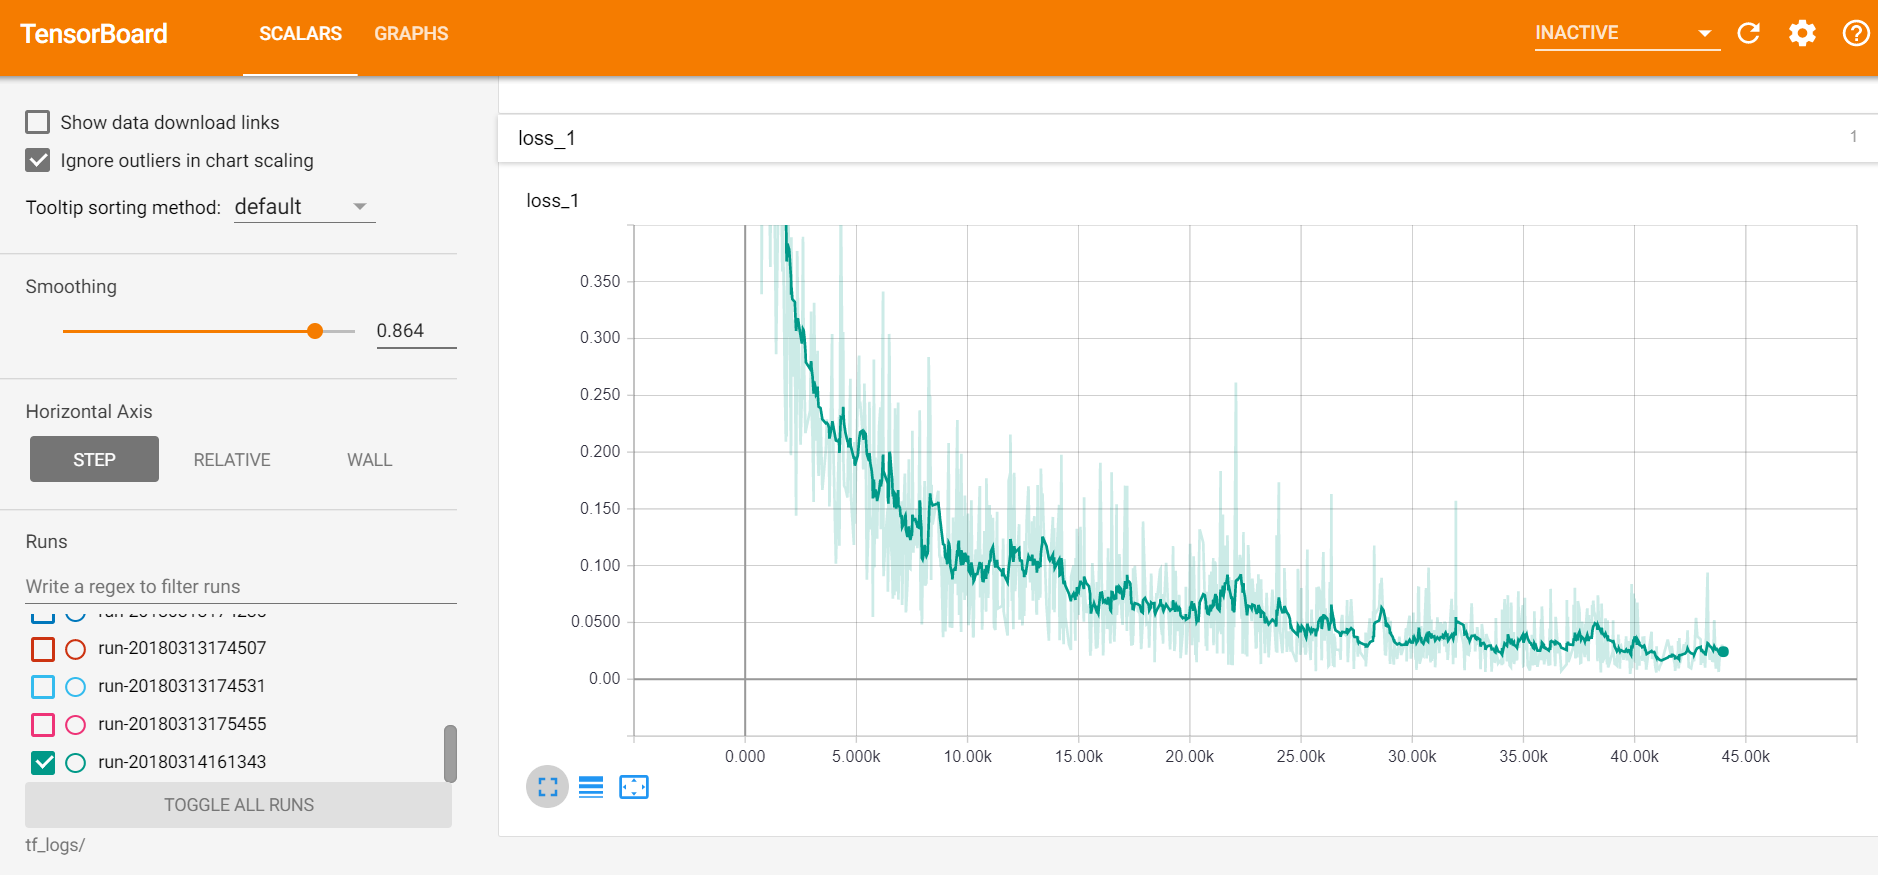

In [14]:
from IPython.display import Image
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' + 
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images\\BathcNormalization_LossFunction.png', 
      width = 900)

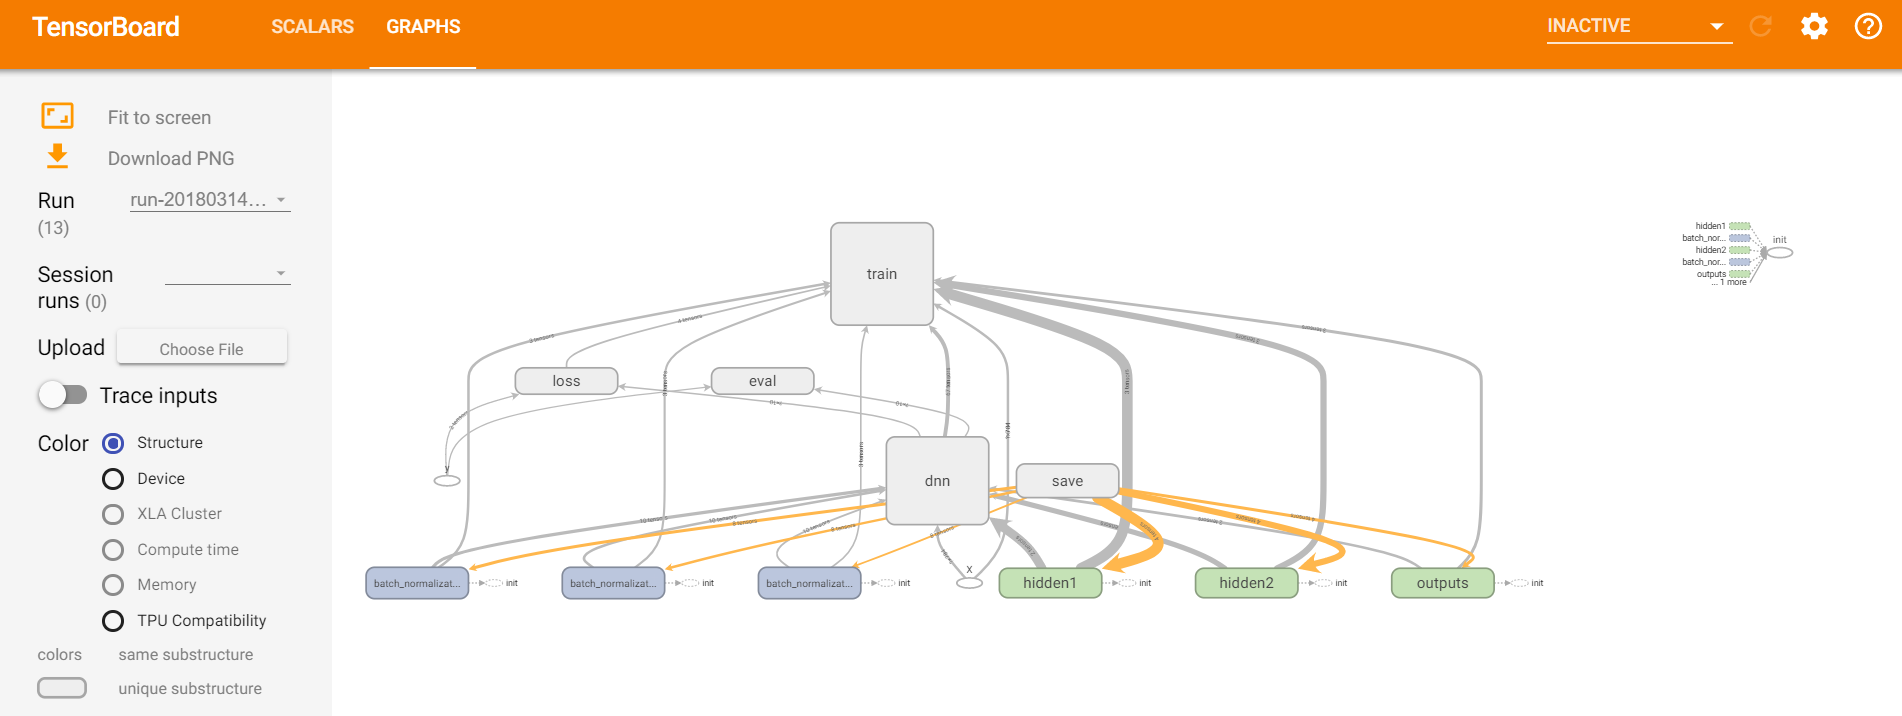

In [13]:
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' + 
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images\\BathcNormalization_tensorboard.png', 
      width = 900)

# (D) Gradient Clipping (To address gradient exploding problem)
Here we simply clip gradient during back propogatoin so that the never exceed some threshold. But people are now preferring batch normalization. Threshold is a hyperparameter that we can tune

We have to make some changes in the step 5 of the code if we are implementing clipping the changes to the code will look like this 

```python
threshold = .1
optimizer =  tf.GradientDescnetOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad_and_vars, -threshold, threshold),var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)
```

# (E) Reusing pretrained Layers

## Reusing a tensor model

### CASE 1: we know the names of the variables and operations of the tensor model that we are reusing
```python
#import_meta_graph helps to load the operations into a default graph
saver = tf.train.import_meta_graph("./finalmodel.ckpt.meat")
#we must get tensors and operations for training
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")
```

### CASE 2: We dont know the names of the variables and operations of the tensor model 
In the above case we can do two things  

**Solution 1**  
Explore the graph on tensorboard 

**Solution 2**  
use get_operations() method 
```python
for op in tf.get_default_graph().get_operations():
    print(op.name)
```

### Best Practice to build and share tensorflow model for easy reuse

**Best Practice 1**   
Give clear names and well document

**Best PRactice 2**  
```python
#Store all the operations and variables in a collection 
for op in (X,y, accuracy, training_op):
    tf.add_to_collection("my_important_ops",op)
```
While retreiving the operations for reusing the above model just write

```python
X,y, accuracy, training_op = tf.get_collection("my_important_ops",op)

with tf.Session as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    [....] #train the model on your own data
```

## How to only reuse part of the pretrained model- usually lower layers

Note  
* use saver to restore the pretrained model (specifying which variables you want to restore ; otherwise, tensorflow will complain that the graphs do not matvh). 

Steps
1. build a new model making sure to copy original model's hidden laters 1 to 3  
2. then we get lis of all variables in hidden layers 1 to 3 using the regex "hidden[123]"  
3. Next, we create a dictionary that maps the name of each variable in th eoriginal model to its new model(generally we keep same names for variales in both new and old models)
4. Then we create a Saver that will restore only these variables
5. Next we create an operations to initalize all variables new and old
6. We also create a saver to save the new model
7. Finally we run the session and initialize all variables, then restore variables value from original model . Finally we train the model on new task and save it  

```python
[...] # build the new model with the same hidden layers 1-3 as before

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "hidden[123]") #Regula expression
reuse_vars_dict = dict( [ (var.op.name, var) for var in reuse_vars]  )
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer() #to initialize all variables new and old
saver = tf.train.Saver() #to save the new model

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "/mymodelfinal.ckpt")
    [...] #train the model
    save_path = saver.save(sess, "/mynewmodel.ckpt")
```

**Note**  
Reusing models from other frameworks this can be quite tedious and varies case by case

### Freezing Lower Layers 

#### Method1: Give optimizer the list of variables to be trained
```python
train_vars = tf.get_collection(tf.GraphKeys.TRAINALE_VARIABLES, scope = "hidden[34]outputs")  
training_op = optimizer.minimize(loss, var_list = train_vars)  
```

#### Method2: Add a stopgraident(). any layer below it will be frozen
Here we are using lower 3 layers from previously built model but we freeze 2 layers and train remaining 4th layer is completely new
```python
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X,n_hidden1, activation = tf.nn.relu, name = "hidden1") #reused frozen
    hidden2 = tf.layers.dense(hidden1,n_hidden2, activation = tf.nn.relu, name = "hidden2") #reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop,n_hidden3, activation = tf.nn.relu, name = "hidden3") #reused notfrozen
    hidden4 = tf.layers.dense(hidden3,n_hidden4, activation = tf.nn.relu, name = "hidden4") # NEW
    logits = tf.layers.dense(hidden4,n_outputs, name = "outputs") #reused frozen

```

### Caching Frozen Layer: 
* Since frozen layer wont change we cashe the output of the topmost frozen layer for each taining instance. Instead of going through frozen layer once per epoch we will go through once per training session.

### Best practice to Reuse the model and Freezing 
* First freze all the copied layers
* Next try unfreezing  few higher layers
* Next dropping and replacing the higher layers of the model

### Model Zoo
Check for online databases to get pretrained models

## Unupervised Pretraining (RBM: Restricted Boltzman Machines, Autoencoders, Backpropogation) 

For detailed usupervised pretraining explaination check my Jupyter notebook with name **"Unsupervised learning with DNN"**

* Here when we have large amount of unlabeled data and very less labeled data then we will have to train initial layers of the NN with unlabeled training data using mechanisms such as Restricted Boltzman Machines or Autoencoders.
* here in RBM/ Autoencoders each layer is trained on the previous output layer, all layers except the one being trained is frozen. 
* Once all the layer are trained this way, you can fine tune the network with supervised learning (i.e. with back propogation) in the final layer we use the labeled data over all the pretrained layers and use back propogation as usual to further tune the DNN.

**Note**
* Before 2010 using unsupervised training for DNN models were the norm due to the issue of gradient vanishing even for supervised learning
* Once the vanishing gradient problem was alleviated, it became much more common to train DNN only based on back propogation
* however unsupervised pretraining is still a good option when you have complex task to solve, no similar model available to reuse, a little labeled training data but plenty of unlabeled training data. (People now use autoencoders rather than RBM's)

## Pretraining on Auxiliary task
In this technique where we first train the neural network on auxillary task for which we can easily obtain or generate labeled training data and then reuse the lower layers of that network for your actual tasks. The first neural networks lower layers will learn feature detectors that are reusable by the send NN.

**Example**  
If you want to build a system to recognize faces, you may only have few pics of each individual-clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. However you could gather a lot of pictures of random people on internet and train the first neural networks to detect whether or not the two different pictures feature the same person. Such a network would learn good feature detectors for faces so reusing its lower layers would allow you to train a good face classifer using little training data

**Example**  
Common way of easily creating the labelled data to train first NN for an auxillary task is corrupt a few data and label it as "Bad" and keep rest of them as "good". So first neural net will train to classify good and bad.


# (F) Faster Optimizers
Another way of speed boosting can be done for DNN using Faster optimizers than Gradient descent optimizers
http://ruder.io/optimizing-gradient-descent/index.html#momentum

## (F.1) Batch Gradient Descent
Vanilla gradient descent, aka batch gradient descent, computes the gradient of the cost function w.r.t. to the parameters θ for the entire training dataset:

As we need to calculate the gradients for the whole dataset to perform just one update, batch gradient descent can be very slow and is intractable for datasets that don't fit in memory. Batch gradient descent also doesn't allow us to update our model online, i.e. with new examples on-the-fly.

$$ \theta \text{ is a parameter of the training dataset}$$ 
$$ \theta =  \theta - \eta \nabla_{\theta} J(\theta)$$ 

## (F.2)  Stochastic Gradient Descent
Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$:  

$$ \theta =  \theta - \eta \nabla_{\theta} J(\theta ; x^{(i)}, y^{(i)} )$$ 
SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 

## (F.3) Mini Batch Gradient Descent

Mini-batch gradient descent finally takes the best of both worlds (Batch GD and SGD) and performs an update for every mini-batch of n training examples:  

$$ \theta =  \theta - \eta \nabla_{\theta} J(\theta ; x^{(i:i+n)}, y^{(i:i+n)} )$$ 

## (F.4) Momentum Optimization
https://distill.pub/2017/momentum/  

* SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum as in the image on left.

* Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in Image on right below.It does this by adding a fraction $\beta$ of the update vector of the past time step to the current update vector:

$$ m_t = \beta m_{t-1} + (1- \beta) \eta \nabla_{\theta} J(\theta) $$
$$ \theta = \theta - m_t $$
$$ m_t \leftarrow \text{velocity} $$
$$ \beta \leftarrow \text{friction} $$
$$ \nabla_{\theta} J(\theta) \text{aceleration} $$
$$ \text{the the equation for m_t looks like ARMA process}  $$

* now we have two parameters $ \alpha \text{learning rate} and \beta \text{friction}$ . In practice $\beta = .9 $ works well  
* when starting the training m_t is initialized to 0   
* Here gradient is used as acceleration not as speed. and $\beta$ is resistance/friction that prevents momentum from growing too large
* Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way (until it reaches its terminal velocity if there is air resistance, i.e. $\beta$<1). The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.


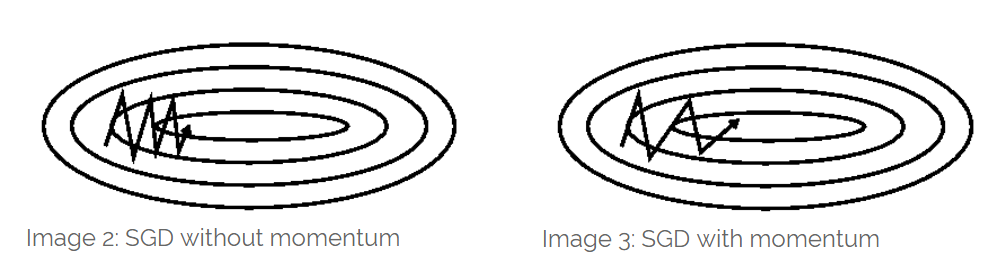

In [16]:
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' + 
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images\\momentum_optimizer.png', 
      width = 500)

**Tensorflow implementation of momentum optimizer**
```python
optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)
```

## (F.5) Nesterov Accelerated Gradient
Idea is to measure gradient o fthe cost function not at the local position but slightly ahead in the direction of the momentum  

$$ m_t = \beta m_{t-1} + (1- \beta) \eta \nabla_{\theta} J(\theta + \beta m_{t-1}) $$
$$ \theta = \theta - m_t $$

NAG is almost always faster then vanilla momentum optimizer

**Tensorflow implementation of momentum optimizer**
```python
optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9, use_nesterov = True)
```

## (F.6) AdaGrad - Adaptive Sub gradient methods  
https://cs.stanford.edu/~ppasupat/a9online/1107.html  

* AdaGrad is an optimization method that allows different step sizes for different features. It increases the influence of rare but informative feature.  It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data. 
* Previously, we performed an update for all parameters θ at once as every parameter θi used the same learning rate η. As Adagrad uses a different learning rate for every parameter θi at every time step t  

$ g_{t,i} \leftarrow  \nabla_{\theta} J(\theta_{t,i} )$ 
$ G_{t,ii} \leftarrow \text{is a diagonal matrix where each diagonal element i,i is the sum is the sum of the squares of the gradients w.r.t. $\theta_i$ up to time step $t$} $
$ \epsilon \leftarrow \text{ is a smoothing term that avoids division by zero (usually on the order of 1e−8)} $

$$ \theta_{t+1,i} =  \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \text{ } \nabla_{\theta} J(\theta ; x^{(i)}, y^{(i)} )$$ 

### AdaGrad Algorithm other way of representation

$$ \text{1. } s  \leftarrow s + \nabla_\theta j(\theta)  ⊗  \nabla_\theta j(\theta)$$

$$ \text{2. } \theta \leftarrow \theta - \eta \nabla_\theta ⦸ \sqrt{s+\epsilon}  $$

$⊗ \text{synmbol represents elementwise multiplication} $  
$⦸ \text{synmbol represents elementwise division} $  

**Step1**  

$ s : \text{Accumulates square of the gradients into the vector s in step1}$   

The vectorised form is equivalent to  
$ s_i \leftarrow s_i +(\frac{\delta j(\theta)}{\delta \theta_i})^2$   
for each element of the vector s. In other words each $s_i$ accumulates the square of the partial derivative of costfunction with respect to parameter $\theta_i$. If the cost function is steep along $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration

**Step2**  
This vectorised form is equivalent to computing
$ \theta_i \leftarrow \theta_i - \eta \frac{(\frac{\delta j(\theta)}{\delta \theta_i})}{\sqrt{s+\epsilon}}$   for all parameters $ \theta_i $ simultaneously  

The gradient vector is scaled down by a factor of $\sqrt{s+\epsilon}$  
$\epsilon $ is the smoothing term to avoid division by zero usually set to $10^{-10}$

**Important Note: What problem AdaGrad Solve**
* Algo decays learning rate but it does so faster for steep dimension than for dimension with gentler slope. This is **called adaptive learning rate.**
* So earlier with just one gradient for all parameters we were actually undermining those parameters which come less frequently during training (Sparse features)
* Some features can be extremely useful and informative to an optimization problem but they may not show up in most of the training instances or data. If, when they do show up, they are weighted equally in terms of learning rate as a feature that has shown up hundreds of times we are practically saying that the influence of such features means nothing in the overall optimization (it's impact per step in the stochastic gradient descent will be so small that it can practically be discounted). To counter this, AdaGrad makes it such that features that are more sparse in the data have a higher learning rate which translates into a larger update for that feature

**PROBLEM**
* AdaGrad often performs well on simple quadratic problems but often it stops too early while training NN. The learning rate gets scaled down so much that algorithm ends up stopping entirely before reaching the global optimum.  
* This problem mainly happens because of the term $G_{t,ii}$, which accumulates the squared gradients in the denominator: Since every added term is positive, the accumulated sum keeps growing during training. This in turn causes the learning rate to shrink and eventually become infinitesimally small, at which point the algorithm is no longer able to acquire additional knowledge

## (F.7) RMSProp  : Root mean Square Prop 

* It was developed to resolve Adagrad's radically diminishing learning rates. Instead of inefficiently storing w previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients.  

$$ \text{1. } s  \leftarrow \beta s + (1-\beta) \nabla_\theta j(\theta)  ⊗  \nabla_\theta j(\theta)$$

$$ \text{2. } \theta \leftarrow \theta - \eta \nabla_\theta ⦸ \sqrt{s+\epsilon}  $$

$ \beta \leftarrow {Decay rate beta}$
* Divides the learning rate by an exponentially decaying average of squared gradients. Hinton suggests $\gamma$ to be set to 0.9, while a good default value for the learning rate $\eta$ is 0.001.

**Implementing RMSProp in tensor flow**  
```python
optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate, momentum = 0.9, decay = 0.9, epsilon = 1e-10)
```

**NOTE**  
* Except on very simple problems RMSProp almost always performs better than AdaGrad
* It generally converges faster than NAG and Momentum optimizers
* It was preferred optimization algorithm until Adam Optimization came around

## (F8) Adam Optimization: Adaptive moment estimation
* It combines the idea of momentum optimization and RMSProp: just like momentum optimization it keeps track of an exponential decaying average of past gradient and just like RMSProp it keeps track of decaying average of past squared gradients

### Adam algorithm

$ \text{1. }$ $$ m \leftarrow \beta_1 m + (1- \beta_1) \nabla_{\theta} J(\theta) $$

$\text{2. }$ $$  s  \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta j(\theta)  ⊗  \nabla_\theta j(\theta)$$

$\text{3. }$ $$ m \leftarrow \frac{m}{1-\beta_1^T} $$

$ \text{4. }$ $$ s \leftarrow \frac{s}{1-\beta_2^T}$$

$\text{5. }$ $$  \theta \leftarrow \theta - \eta m ⦸ \sqrt{s+\epsilon}  $$

$ T : \text{Iteration number or, which epoch iteration} $

* Step 1,2 and 5 shows very close similarity to RMSProp and Momentum optimization
* Step 3,4 are somewhat of technical detail since m and s are initialized at 0, they will be biased toward 0 at the beginning of training so these two steps will help boost m and s at the beginning of the training
* $\beta_1$ is initialized to 0.9
* $\beta_2$ is initialized to 0.999
* $\epsilon $ is initialized to $10^{-8}$

* These are also default values of tensor flow

```python
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
```
* emperically since Adam is a adaptive learnig rate algorithm we can often use default value $\eta = 0.001$

# (G) Sparse Models and Dense Models

* All the optimizers used above produce dense models.
* **Dense Models** This means that model produced has most of its parameters non zero  
* If you need a blazingly fast model at running or if you need it to take up less memory you may prefer to end up with a sparse model insted.
 
 ### Simple ways of Achieving sparse model. Below are the three ways
 1. Get rid of tiny weights (set them to 0): this is naive approach
 2. Apply $ \ell_1 $ regularization during training as it pushes optimizers to zero out as many weights as it can
 3. Apply **Dual averaging** often called **FTLR (Follow The Regularized leader)**. When this technique is used with $\ell_1$ regularization this opften produces very sparse models 

# (H) Learning Rate Scheduling

* Learning rate sheduling is a strategy to start with high learning rate and keep reducing as it stops making fast progress. this helps us reach good solution faster than having constant learning rate.
* Since AdaGrad, RMSProp and Adam optimiztion automatically reduce the learning rate durung training it is not necessary to add an extra learning schedule . For other optimization algorithms using exponential decay or perfrmance scheduling can considerably speed up convergence
* **Problems addressed by having LEarning rate sheduling which is a form of adaptive learning rate are**
    * $\eta$ too small rearing takes a lot of time
    * $\eta$ too big, it will make good progress in the beginning but keeps dancing around the optimum
    * $\eta $ decaying at very high rate that the algorithm doesnot reach global minima  

Below is the drawing from Andrew NG learning rate decay video. Blue line represents learning with constant gradient alpha which goes towards the global minimum but keeps bouncing around but never really converges since the alpha is constant and due to noise in minibatches. But if we take a learning rate approach as shown by green line which is high in the beginning and keeps decaying as the learning goes closer towards global minima then we will will oscillate in much tighter region near global minima.

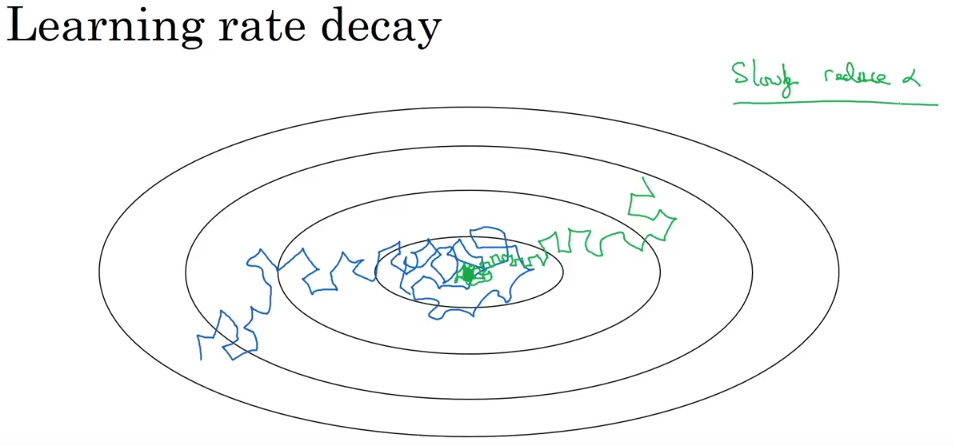

In [3]:
from IPython.display import Image
Image('C:\\Users\\Ashlesh B Shetty\\Desktop\\ZZ\\JobSearch\\GitHubRepos' + 
      '\\DeepLearning-ArtificialIntelligence_ScikitLearn-TensorFlow\\images\\LearningRateDecay1.png', 
      width = 500)

### Some common strategies for learning scheduling

#### Predetermined piecewise constant learning rate:
* Here the learning rate is hardcoded to change at every desired epoch iteration

#### Performance scheduling
* Here learning rate is reduced by a factor $\lambda $ when the learning stops or error stops dropping

#### Exponential scheduling
* Here learning rate is reduced by a factor of 10 for every $r $ iterations. This works great but will now require tuning of $\eta_0$ and $r$

$$ \eta(t) = \frac{\eta_0}{10^{t/r} } $$
$ t : epoch number $ 
$ r : \text{learning rate will drop by a factor of 10 every r steps} $

#### Power scheduling: It is simple exponential smoothing

$$ \eta(t) = \frac{\eta_0}{(1+ t/r)^c} $$
Here the learning rate drops much more slowly and we will have to tune the hyperparameter c

**Note**
One good way to test which learning rate works well is before starting to train check all the learning rate options with less eopchs. Now compare all the learning curves and choose the good one. A good learning curves will learn quickly and converges to a good solution.

## Implementing learning scheduling with tensor flow
```python
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable =False, name ="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
optimizer = tf.train.MomentumOptimize(learning_rate, momentum =0.9)
training_op = optimizer.minimize(loss, global_step = global_step)
```

In the above code   
r = 10000  
$\eta_0 = 0.1$  
global_step: a non trainable variable is created to keep track of current iteration number  
Finally we create the training operation by calling optimizer's minimize metod. Since we pass the global_step variable it will kindly take care of incrementing it

# (I) Avoid overfitting throught regularization
Few famous ones in DNN doamins are  
* Early stopping 
* $\ell_1$ regularization
* $\ell_2$ regularization
* drop out
* max-norm regularization
* data augmentation

## (I.1) Early Stopping
* Interrupt training when the performance on the validation set starts droping
* Implementation example: evaluate model on evaluation. Save a winner snapshot if it outperforms previous winner snapshot.Count the number of steps since last winner snapshots was saved and interrupt when the number reaches some limit. The restore the last winner snapshot.
* combine early stopping with regulariztion for further better performance

## (I.2) $ \ell_1$ and $ \ell_2$ regularization

Tensorflow implementation

```python
#adds regularization component to dense layer
my_dense_layer = partial(tf.layers.dense, 
                         activation = tf.nn.relu,
                         kernel_regularizer = tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X,n_hidden1, name ="hidden1")
    hidden2 = my_dense_layer(hidden1,n_hidden2, name ="hidden2")
    logits  = my_dense_layer(hidden2,n_outputs, activation = None, name ="outputs")

#Tensorflow automatically adds these regularization nodes in the graph to a special collection containing all the regularization losses to the overall loss.

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([base_loss] + reg_loss, name = "loss")
```

## (I.3) DropOut (Most popular regularization technique)

### Technique
* At every training step every neuron (including input excluding output neurons) has a probability of p (the hyperparameter p is called dropout rate and it is usually set to 50%) of being temporarily dropped out, meaning it will be entirely ignored during this training step but it may be active in the next training step. After training neuron don't get dropped any more.

### Reasoning for its success
1. Neuron trained with dropout cannot co-adapt with the neighbouring neurons. They have to be useful as possible on their own.
2. they neurons also cannot excessivly rely on few input neurons. They end up being less sensitive to slight changes to inputs. Therefore in the end we get a more robust network that generalizes better.
3. The end result acts like a ensemble model: Since each neuron can either be present or absent there is a total of $2^N$ possible networks. This is such a huge number that it is virtually impossible for for the same neural network to be sampled twice. These neural networks might not be indepndent but they are nevertheless all different. Therefore resulting neural networkcan be seen as aand averaging ensemble of all the small eural network.

### Testing phase adjustment when dropout is implemented for training phase
* Suppose p =50%, in which case testing neuron will be connected to twice as many input neurons as it was (on average) during training. To compensate for this fact we can do two things
    1. we need to **MULTIPLY each neuron's INPUT connection with keep probability that is 1-p (that is 1-.5 in our case) AFTER training**
    2. OR we can **DIVIDE each neurons OUTPUT by keep probability DURING training**

### Tensor flow implementation of Dropout where in training itself it divides the output of each neuron with keep probability

```python
[...]
training = tf.placeholder_with_default(False, shape =(), name = "training")

dropout_rate = 0.5 #keep prob = 1-dropoutrate
X_drop = tf.layers.dropout(X,dropout_rate, training = training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation = tf.nn.relu, name = "hidden1")
    hidden1drop = tf.layers.dropout(hidden1, dropout_rate, training = training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activatio = tf.nn.relu, name = "hidden2")
    hidden2drop = tf.layers.dropout(hidden2 dropout_rate, training = training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name = "outputs")
```

* of course like in batch normalization we need to set training to true when training and leave the default false when testing  
* If model overfits increase the drop rate 
* if model underfits reduce the droprate
* Drop out rate can also be set differentlyfor each layer. Generally dropout rate being higher for larger layer and lower for smaller layer works well  

**Disadvantage**
* Dropout method takes significantly more time to converge, but it usually results in much better models which id worth the extra time  


## (I.4)  Max-Norm Regualrization

* For each neuron, it constraints the weights $w$ of the incoming connections such that  
    $|| w ||_2 \leq r$   
    where $||.||_2$ is $ \ell_2$ regularization   and r is the max-norm hyperparameter  

* we typically implement this constraint by computing $|| w ||_2 $ after each training step and clipping $w $ if needed. and the clipping value w is calculated by 

$$ w \leftarrow w \frac{r}{|| w ||_2 }$$




## (I.5) Data Augmentation
* here we generate new training instances from existing ones, artificially boosting the size of the training set. This reduces overfitting making this a regularization technique.
* Simply adding whitenoise will not help, modification we apply should be learnable

**Example**
* Suppose I'm training my neural net to identify mushroom and I wnat to make the network more tolerant to orinetation then I will generate images with various orientation zoooms etc from the existing images. Or if I want to make it more tolerant towards lighting conditions then I will create new images from existing images with different brightness.

* Generally we dont do the image transformation and store we do it on the fly using functions. Even tensorflow has some readymade image transformation fuctions